In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Tuple, List
import os
import re

In [2]:
def parse_filenames(df: pd.DataFrame) -> pd.DataFrame:
    """Processes a DataFrame to extract sample name, cleaning method, proportion, and mix method.
    
    It reads from a column 'Unnamed: 0', creates 'sample_name',
    'clean_method', 'proportion', and 'mix_method' columns, and then drops 
    the original column.

    Args:
        df: The input pandas DataFrame.

    Returns:
        A new DataFrame with the processed columns.
    """
    
    # Work on a copy to avoid side effects and SettingWithCopyWarning
    df_copy = df.copy()
    
    # The name of the column containing the filenames
    filename_col = 'Unnamed: 0'

    def parse_filename(filename: str) -> Tuple[str, str, str, str]:
        """Parses a filename string to extract sample name, cleaning method, proportion, and mix method.

        Args:
            filename: The filename string to parse.

        Returns:
            A tuple containing the sample name, clean method, proportion, and mix method.
        """
        
        # Clean the filename by removing the extension and any whitespace
        clean_name = filename.replace('.fcs', '').strip()
        
        sample_name_base = ''
        clean_method = ''
        
        # Logic to handle different filename formats to extract clean_method
        if clean_name.startswith('flowmop_'):
            clean_method = 'flowmop'
            sample_name_base = clean_name.removeprefix('flowmop_')
        elif clean_name.endswith('_flowcut'):
            clean_method = 'flowcut'
            sample_name_base = clean_name.removesuffix('_flowcut')
        elif clean_name.endswith('_peacoqc'):
            clean_method = 'peacoqc'
            sample_name_base = clean_name.removesuffix('_peacoqc')
        else:
            sample_name_base = clean_name

        # Extract mix_method and proportion from the sample_name
        parts = sample_name_base.split('_')
        
        mix_method = ''
        proportion = ''
        sample_name = ''

        if len(parts) > 2:
            mix_method = parts[-1]
            proportion_str = parts[-2]
            sample_name = '_'.join(parts[:-2])

            # Use regex to split the proportion string into 2-digit chunks
            proportions_list = re.findall(r'(\d{2})', proportion_str)
            proportion = ','.join(proportions_list)
        else:
            sample_name = sample_name_base
            
        return sample_name, clean_method, proportion, mix_method

    # Apply the parsing function to the column to create new columns
    df_copy[['sample_name', 'clean_method', 'proportion', 'mix_method']] = df_copy[filename_col].apply(
        lambda name: pd.Series(parse_filename(name))
    )
    # Drop the original 'Unnamed: 0' column
    df_processed = df_copy.drop(columns=[filename_col])
    
    return df_processed

In [3]:
synth_dir = r"C:\Users\Tony\Documents\github_remotes\FlowMOP\figs_data\fig_2_data\fig_2_analysis"
csvs = [f for f in os.listdir(synth_dir) if f.endswith('.csv')]
normal_times = [pd.read_csv(synth_dir + "\\" + csv) for csv in csvs if 'combos' in csv]
smallcut_times = [pd.read_csv(synth_dir + "\\" + csv) for csv in csvs if 'smallcut' in csv]
for i, time in enumerate(normal_times): 
    normal_times[i] = normal_times[i][~normal_times[i]['Unnamed: 0'].str.contains('Mean', na=False)]
    normal_times[i] = normal_times[i][~normal_times[i]['Unnamed: 0'].str.contains('SD', na=False)]
for i, time in enumerate(smallcut_times): 
    smallcut_times[i] = smallcut_times[i][~smallcut_times[i]['Unnamed: 0'].str.contains('Mean', na=False)]
    smallcut_times[i] = smallcut_times[i][~smallcut_times[i]['Unnamed: 0'].str.contains('SD', na=False)]

In [4]:
for i, time in enumerate(normal_times): 
    normal_times[i] = parse_filenames(time).sort_values(by=['sample_name',"mix_method","proportion"]).reset_index(drop=True)

overall_counts_normal = normal_times[1]["Count"]

# Some specific reformatting
normal_times[1]["Count"] = overall_counts_normal * normal_times[1]["passedtime | Freq. of Parent (%)"]/100
normal_times[1].drop(columns=["passedtime | Freq. of Parent (%)","Unnamed: 6"], inplace=True)
normal_times[0].drop(columns=["Unnamed: 5"], inplace=True)
normal_times[2].drop(columns=["Unnamed: 5"], inplace=True)

In [5]:
for i, time in enumerate(smallcut_times): 
    smallcut_times[i] = parse_filenames(time).sort_values(by=['sample_name',"mix_method", "proportion"]).reset_index(drop=True)

overall_counts_smallcut = smallcut_times[1]["Count"]

# Some specific reformatting
smallcut_times[1]["Count"] = overall_counts_smallcut * smallcut_times[1]["passedtime | Freq. of Parent (%)"]/100
smallcut_times[1].drop(columns=["passedtime | Freq. of Parent (%)","Unnamed: 6"], inplace=True)
smallcut_times[0].drop(columns=["Unnamed: 5"], inplace=True)
smallcut_times[2].drop(columns=["Unnamed: 5"], inplace=True)

In [6]:
def rename_freq_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renames columns containing 'Freq. of Parent' to a simplified 'sample_n' format.
    The renaming is sequential.

    For example, '1 | Freq. of Parent (%)' becomes 'sample_1' and 
    'passedtime subset | Freq. of Parent (%)' also becomes 'sample_1'.

    Args:
        df: The pandas DataFrame with columns to be renamed.

    Returns:
        The DataFrame with renamed columns.
    """
    df_copy = df.copy()
    
    rename_map = {}
    sample_counter = 1
    
    # Find all columns that need renaming, maintaining their order.
    cols_to_rename = [col for col in df_copy.columns if 'Freq. of Parent' in col]

    # Generate the new names sequentially.
    for col_name in cols_to_rename:
        rename_map[col_name] = f'sample_{sample_counter}'
        sample_counter += 1
            
    df_copy.rename(columns=rename_map, inplace=True)
    return df_copy

# This loop assumes 'time_data' is a list of DataFrames.
# Also adding overall counts
for i in range(len(normal_times)):
    normal_times[i] = rename_freq_columns(normal_times[i])
    normal_times[i]["original_counts"] = overall_counts_normal
for i in range(len(smallcut_times)):
    smallcut_times[i] = rename_freq_columns(smallcut_times[i])
    smallcut_times[i]["original_counts"] = overall_counts_smallcut

In [7]:
for i, time in enumerate(normal_times): 
    normal_times[i]["passed_time"] = normal_times[i]["Count"]/overall_counts_normal
for i, time in enumerate(smallcut_times): 
    smallcut_times[i]["passed_time"] = smallcut_times[i]["Count"]/overall_counts_smallcut

In [8]:
def calculate_target_proportions(proportion_str: str) -> tuple:
    """
    Calculates target proportions where the highest value(s) get 100 split evenly,
    and all other values get 0.
    
    Args:
        proportion_str: A comma-separated string of proportions (e.g., '20,80' or '40,40,20')
    
    Returns:
        A tuple of three values representing the target proportions for samples 1, 2, and 3
    """
    if not proportion_str or proportion_str == '':
        return (0, 0, 0), (0, 0, 0)
    
    # Parse the proportion string into a list of integers
    proportions = [int(p) for p in proportion_str.split(',')]
    
    # Pad with zeros if fewer than 3 values
    while len(proportions) < 3:
        proportions.append(0)
    
    # Find the maximum value
    max_value = max(proportions)
    
    # If all proportions are 0, return (0, 0, 0)
    if max_value == 0:
        return (0, 0, 0), (0, 0, 0)
    
    # Count how many times the maximum appears
    max_count = proportions.count(max_value)
    
    # Calculate the split value
    split_value = max_value / max_count
    
    # Create the target proportions
    targets = []
    for prop in proportions[:3]:  # Only consider first 3 values
        if prop == max_value:
            targets.append(split_value)
        else:
            targets.append(0)
    return targets, proportions


def add_target_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'target_1', 'target_2', and 'target_3' columns based on the 'proportion' column.

    The mapping from 'proportion' to targets is calculated dynamically where the highest
    proportion(s) get 100 split evenly, and all others get 0.

    Args:
        df: The pandas DataFrame with a 'proportion' column.

    Returns:
        The DataFrame with the new target columns.
    """
    df_copy = df.copy()

    # Apply the dynamic calculation for targets
    df_copy['proportion'].apply(calculate_target_proportions)
    targets = df_copy['proportion'].apply(calculate_target_proportions)
    # Extract the first and second elements from each tuple
    original_proportions = [tup[1] for tup in targets]
    targets = [tup[0] for tup in targets]
    # Create the new columns from the list of tuples.
    df_copy[['target_1', 'target_2', 'target_3']] = pd.DataFrame(targets, index=df_copy.index)
    df_copy[['original_1', 'original_2', 'original_3']] = pd.DataFrame(original_proportions, index=df_copy.index)

    return df_copy

alltime_normal = pd.concat(normal_times)
alltime_normal = add_target_columns(alltime_normal)

alltime_smallcut = pd.concat(smallcut_times)
alltime_smallcut = add_target_columns(alltime_smallcut)

In [10]:
# Weird flowjo outputs mean need to int and float stuff
alltime_normal["Count"] = alltime_normal["Count"].astype(int)

# Define the columns that need to be cleaned and converted
sample_cols = ['sample_1', 'sample_2', 'sample_3']
other_numeric_cols = ['Count', 'original_counts', 'target_1', 'target_2', 'target_3']

# Clean and convert the 'sample' columns
for col in sample_cols:
    # Replace the malformed 'E?' with 'E-' and convert to a numeric type
    alltime_normal[col] = pd.to_numeric(
        alltime_normal[col].astype(str).str.replace('E?', 'E-', regex=False),
        errors='coerce'
    )

# Weird flowjo outputs mean need to int and float stuff
alltime_smallcut["Count"] = alltime_smallcut["Count"].astype(int)

# Define the columns that need to be cleaned and converted
sample_cols = ['sample_1', 'sample_2', 'sample_3']
other_numeric_cols = ['Count', 'original_counts', 'target_1', 'target_2', 'target_3']

# Clean and convert the 'sample' columns
for col in sample_cols:
    # Replace the malformed 'E?' with 'E-' and convert to a numeric type
    alltime_smallcut[col] = pd.to_numeric(
        alltime_smallcut[col].astype(str).str.replace('E?', 'E-', regex=False),
        errors='coerce'
    )


In [11]:
def correct_remove(sample_count, target_count, original_count):
    if target_count == 0: 
        return original_count - sample_count
    else: 
        return 0

def correct_keep(sample_count, target_count):
    if target_count == 0: 
        return 0
    else: 
        return sample_count
    
def incorrect_remove(sample_count, target_count):
    if target_count == 0: 
        return 0
    elif sample_count < target_count:
        return (target_count - sample_count)
    else: 
        return 0

def incorrect_keep(sample_count, target_count):
    if target_count == 0: 
        return sample_count
    elif sample_count > target_count:
        return (sample_count - target_count)
    else: 
        return 0

In [12]:
for k in range(1,4):
    alltime_normal[f"sample_{k}_count"] = alltime_normal[f"sample_{k}"]/100 * alltime_normal["Count"]
    alltime_normal[f"target_{k}_count"] = alltime_normal[f"target_{k}"]/100 * alltime_normal["original_counts"]
    alltime_normal[f"original_{k}_count"] = alltime_normal[f"original_{k}"]/100 * alltime_normal["original_counts"]
    alltime_normal[f"correct_remove_{k}"] = alltime_normal.apply(lambda row: correct_remove(row[f"sample_{k}_count"], row[f"target_{k}_count"], row[f"original_{k}_count"]), axis=1)
    alltime_normal[f"correct_keep_{k}"] = alltime_normal.apply(lambda row: correct_keep(row[f"sample_{k}_count"], row[f"target_{k}_count"]), axis=1)
    alltime_normal[f"incorrect_remove_{k}"] = alltime_normal.apply(lambda row: incorrect_remove(row[f"sample_{k}_count"], row[f"target_{k}_count"]), axis=1)
    alltime_normal[f"incorrect_keep_{k}"] = alltime_normal.apply(lambda row: incorrect_keep(row[f"sample_{k}_count"], row[f"target_{k}_count"]), axis=1)

In [13]:
for k in range(1,4):
    alltime_smallcut[f"sample_{k}_count"] = alltime_smallcut[f"sample_{k}"]/100 * alltime_smallcut["Count"]
    alltime_smallcut[f"target_{k}_count"] = alltime_smallcut[f"target_{k}"]/100 * alltime_smallcut["original_counts"]
    alltime_smallcut[f"original_{k}_count"] = alltime_smallcut[f"original_{k}"]/100 * alltime_smallcut["original_counts"]
    alltime_smallcut[f"correct_remove_{k}"] = alltime_smallcut.apply(lambda row: correct_remove(row[f"sample_{k}_count"], row[f"target_{k}_count"], row[f"original_{k}_count"]), axis=1)
    alltime_smallcut[f"correct_keep_{k}"] = alltime_smallcut.apply(lambda row: correct_keep(row[f"sample_{k}_count"], row[f"target_{k}_count"]), axis=1)
    alltime_smallcut[f"incorrect_remove_{k}"] = alltime_smallcut.apply(lambda row: incorrect_remove(row[f"sample_{k}_count"], row[f"target_{k}_count"]), axis=1)
    alltime_smallcut[f"incorrect_keep_{k}"] = alltime_smallcut.apply(lambda row: incorrect_keep(row[f"sample_{k}_count"], row[f"target_{k}_count"]), axis=1)

In [14]:
alltime_normal["target_count_overall"] = sum(
    [alltime_normal["target_1_count"], alltime_normal["target_2_count"], alltime_normal["target_3_count"]])
alltime_normal["sample_count_overall"] = sum(
    [alltime_normal["sample_1_count"], alltime_normal["sample_2_count"], alltime_normal["sample_3_count"]])

alltime_normal["correct_keep_overall"] = sum(
    [alltime_normal["correct_keep_1"], alltime_normal["correct_keep_2"], 
     alltime_normal["correct_keep_3"]]
     )/alltime_normal["Count"] # Counts to see how many of the ones we have here are correct
alltime_normal["incorrect_keep_overall"] = sum(
    [alltime_normal["incorrect_keep_1"], alltime_normal["incorrect_keep_2"], 
     alltime_normal["incorrect_keep_3"]]
     )/alltime_normal["Count"] # Counts to see how many of the ones we have here are incorrect

# Dividing by the difference of the number of cells that we have removed 
alltime_normal["correct_remove_overall"] = sum(
    [alltime_normal["correct_remove_1"], alltime_normal["correct_remove_2"], 
     alltime_normal["correct_remove_3"]]
     )/(alltime_normal["original_counts"]-alltime_normal["Count"]) 

alltime_normal["incorrect_remove_overall"] = sum(
    [alltime_normal["incorrect_remove_1"], alltime_normal["incorrect_remove_2"], 
    alltime_normal["incorrect_remove_3"]]
    )/(alltime_normal["original_counts"]-alltime_normal["Count"])

In [15]:
alltime_smallcut["target_count_overall"] = sum(
    [alltime_smallcut["target_1_count"], alltime_smallcut["target_2_count"], alltime_smallcut["target_3_count"]])
alltime_smallcut["sample_count_overall"] = sum(
    [alltime_smallcut["sample_1_count"], alltime_smallcut["sample_2_count"], alltime_smallcut["sample_3_count"]])

alltime_smallcut["correct_keep_overall"] = sum(
    [alltime_smallcut["correct_keep_1"], alltime_smallcut["correct_keep_2"], 
     alltime_smallcut["correct_keep_3"]]
     )/alltime_smallcut["Count"] # Counts to see how many of the ones we have here are correct
alltime_smallcut["incorrect_keep_overall"] = sum(
    [alltime_smallcut["incorrect_keep_1"], alltime_smallcut["incorrect_keep_2"], 
     alltime_smallcut["incorrect_keep_3"]]
     )/alltime_smallcut["Count"] # Counts to see how many of the ones we have here are incorrect

# Dividing by the difference of the number of cells that we have removed 
alltime_smallcut["correct_remove_overall"] = sum(
    [alltime_smallcut["correct_remove_1"], alltime_smallcut["correct_remove_2"], 
     alltime_smallcut["correct_remove_3"]]
     )/(alltime_smallcut["original_counts"]-alltime_smallcut["Count"]) 

alltime_smallcut["incorrect_remove_overall"] = sum(
    [alltime_smallcut["incorrect_remove_1"], alltime_smallcut["incorrect_remove_2"], 
    alltime_smallcut["incorrect_remove_3"]]
    )/(alltime_smallcut["original_counts"]-alltime_smallcut["Count"])

In [16]:
# Drop the 50:50 ones

# Get the rows where proportion is "50,50"
mask = alltime_normal["proportion"] == "50,50"
group505_normal = alltime_normal[mask].copy()
# Remove those rows from the original dataframe
alltime_normal = alltime_normal[~mask].reset_index(drop=True)

In [17]:
# Drop the 50:50 ones

# Get the rows where proportion is "50,50"
mask = alltime_smallcut["proportion"] == "50,50"
group505_smallcut = alltime_smallcut[mask].copy()
# Remove those rows from the original dataframe
alltime_smallcut = alltime_smallcut[~mask].reset_index(drop=True)

C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\67022681.py:121: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\67022681.py:121: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\67022681.py:121: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\67022681.py:121: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


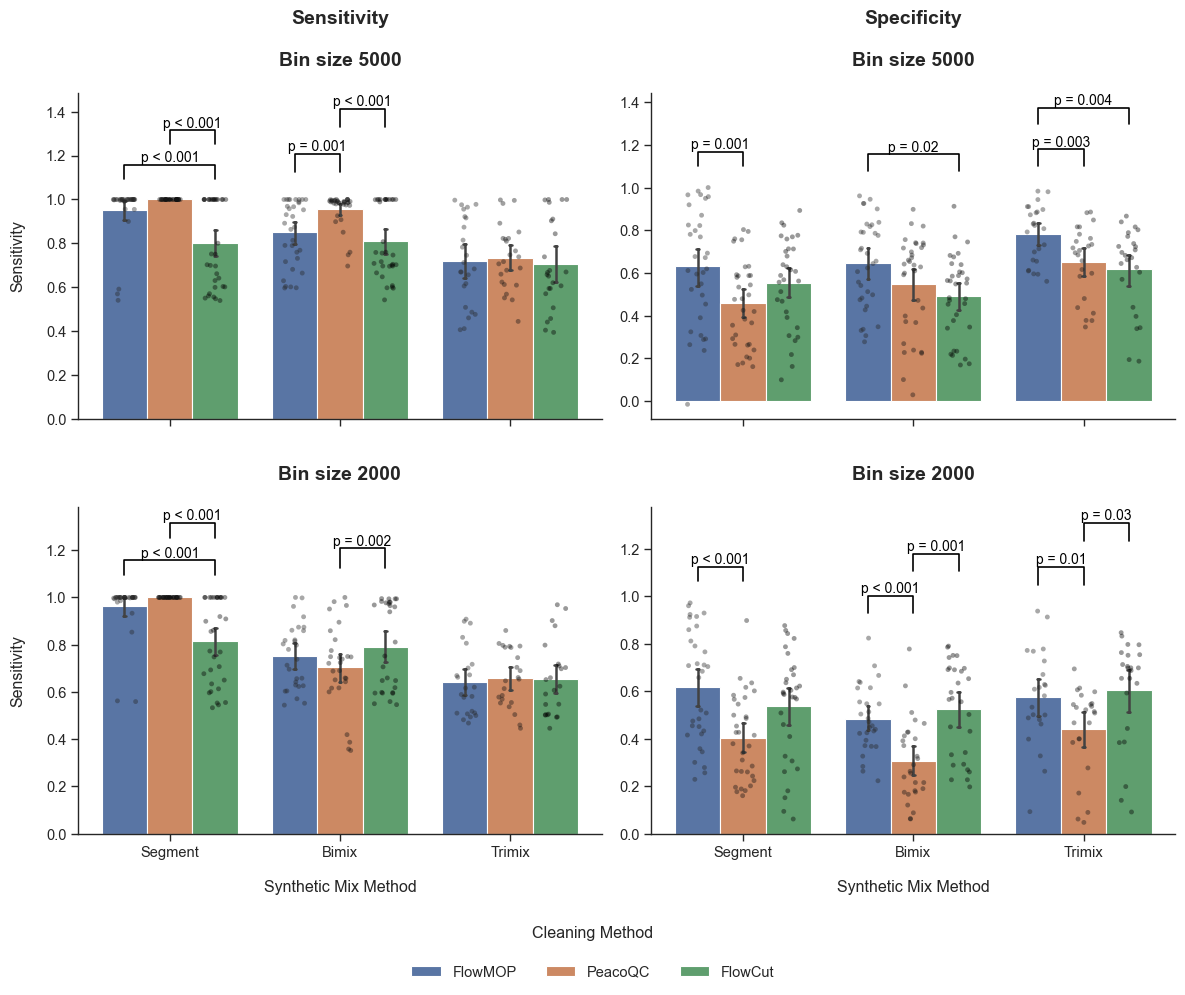

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from itertools import combinations

# --- Helper function for formatting p-values ---
def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return f"p = {p:.3f}"
    else: # p-values between 0.01 and 0.05
        return f"p = {p:.2f}"

# --- Helper function to add statistical annotations (REVISED for Paired T-test) ---
def add_stat_annotation(ax, data, y_col, mix_methods_order, clean_methods_order):
    """
    Performs paired t-tests with Bonferroni correction and adds significance brackets.
    """
    n_mix = len(mix_methods_order)
    
    # Iterate over each primary group on the x-axis
    for mix_idx, mix_method in enumerate(mix_methods_order):
        
        sub_df = data[data['mix_method'] == mix_method]
        
        if len(sub_df['clean_method'].unique()) < 2:
            continue
            
        # --- Paired T-test Logic ---
        # Pivot the data to align samples by 'sample_name' and 'proportion'
        pivoted_df = sub_df.pivot(index=['sample_name', 'proportion'], columns='clean_method', values=y_col)

        # Get all pairwise combinations of cleaning methods
        comparisons = list(combinations(clean_methods_order, 2))
        m = len(comparisons) # Bonferroni correction factor
        sig_results = []
        for group1, group2 in comparisons:
            # Drop rows with NaNs for the pair to ensure samples are properly paired
            pair_df = pivoted_df[[group1, group2]].dropna()
            
            if len(pair_df) < 2: # Need at least 2 pairs for a t-test
                continue

            # Perform the paired t-test
            stat, p_raw = ttest_rel(pair_df[group1], pair_df[group2])
            # Apply Bonferroni correction
            p_adj = min(p_raw * m, 1.0)
            
            if p_adj < 0.05:
                sig_results.append({'group1': group1, 'group2': group2, 'p-adj': p_adj})

        if not sig_results:
            continue
            
        # --- Drawing Logic ---
        group_max = sub_df[y_col].max()
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        y_offset = y_range * 0.06
        
        current_y = group_max + y_offset * 1.5
        
        for result in sig_results:
            group1, group2 = result['group1'], result['group2']
            p_val = result['p-adj']
            
            clean_idx1 = clean_methods_order.index(group1)
            clean_idx2 = clean_methods_order.index(group2)
            
            bar1 = ax.patches[clean_idx1 * n_mix + mix_idx]
            bar2 = ax.patches[clean_idx2 * n_mix + mix_idx]
            x1, x2 = bar1.get_x() + bar1.get_width() / 2, bar2.get_x() + bar2.get_width() / 2
            
            ax.plot([x1, x1, x2, x2], [current_y, current_y + y_offset, current_y + y_offset, current_y], lw=1.2, c='black')
            ax.text((x1 + x2) / 2, current_y + y_offset, format_p_value(p_val), ha='center', va='bottom', color='black', fontsize=10)
            
            current_y += y_offset * 2.5


# --- Main plotting script for 2x2 layout: bin sizes vs correct keep/remove ---

# Prepare data
alltime_normal.reset_index(drop=True, inplace=True)
alltime_normal['mix_method'] = alltime_normal['mix_method'].str.capitalize()

alltime_smallcut.reset_index(drop=True, inplace=True) 
alltime_smallcut['mix_method'] = alltime_smallcut['mix_method'].str.capitalize()

sns.set_theme(style="ticks", context="paper", font_scale=1.2)

# New 2x2 layout: rows = bin sizes, columns = correct keep/remove only
subplot_titles = [
    ["Sensitivity\n \nBin size 5000", "Specificity\n \nBin size 5000"],
    ["\nBin size 2000", "\nBin size 2000"]
]

y_cols = ['correct_keep_overall', 'correct_remove_overall']
mix_methods_order = ["Segment", "Bimix", "Trimix"]
clean_methods_order = ["flowmop", "peacoqc", "flowcut"]
label_titles = ["FlowMOP", "PeacoQC", "FlowCut"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

handles, labels = None, None

# Plot each panel
for row in range(2):  # bin sizes
    data_subset = alltime_normal if row == 0 else alltime_smallcut
    
    for col in range(2):  # correct keep/remove
        ax = axes[row, col]
        y_col = y_cols[col]

        sns.barplot(
            data=data_subset, x='mix_method', y=y_col, hue='clean_method',
            order=mix_methods_order, hue_order=clean_methods_order, ax=ax,
            errorbar=('ci', 95), capsize=.05, palette='deep'
        )
        sns.stripplot(
            data=data_subset, x='mix_method', y=y_col, hue='clean_method',
            order=mix_methods_order, hue_order=clean_methods_order, ax=ax,
            dodge=True, color='black', s=3.5, alpha=0.4, jitter=0.2, legend=False
        )
        
        ax.set_title(subplot_titles[row][col], loc='center', fontsize=14, weight='bold', pad=20)
        
        # Y-axis labels only on left column
        if col == 0:
            if 'keep' in y_col:
                ax.set_ylabel("Sensitivity", labelpad=15)
            elif 'remove' in y_col:
                ax.set_ylabel("Specificity", labelpad=15)
        else:
            ax.set_ylabel("")
            
        # X-axis labels only on bottom row
        if row == 1:
            ax.set_xlabel("Synthetic Mix Method", labelpad=15)
        else:
            ax.set_xlabel("")
            
        if row == 0 and col == 0:
            handles, labels = ax.get_legend_handles_labels()
        if ax.get_legend() is not None:
            ax.get_legend().remove()
            
        add_stat_annotation(ax, data_subset, y_col, mix_methods_order, clean_methods_order)
        


legend = fig.legend(
    handles, label_titles, title='Cleaning Method\n', bbox_to_anchor=(0.5, 0),
    loc='lower center', ncol=len(labels), frameon=False
)
plt.setp(legend.get_title(), multialignment='center')

sns.despine(fig)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\824428489.py:117: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\824428489.py:117: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\824428489.py:117: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\Tony\AppData\Local\Temp\ipykernel_36748\824428489.py:117: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


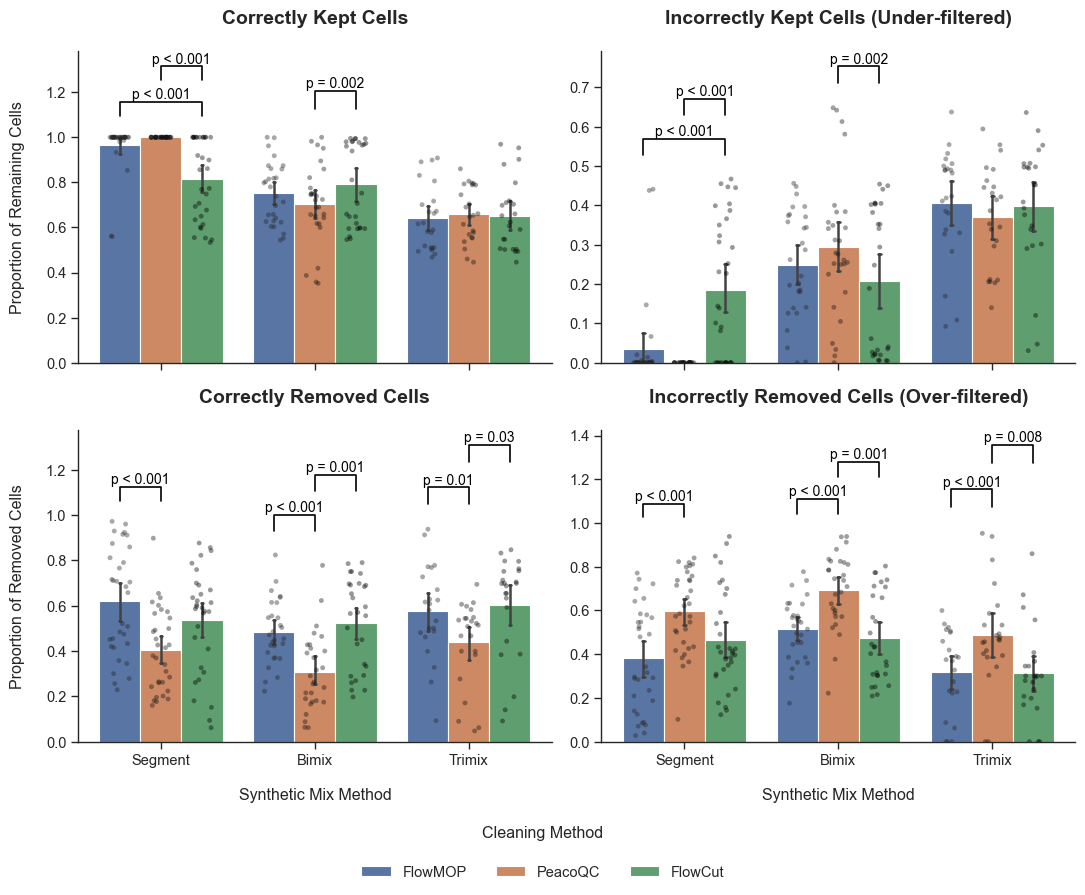

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from itertools import combinations

# --- Helper function for formatting p-values ---
def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return f"p = {p:.3f}"
    else: # p-values between 0.01 and 0.05
        return f"p = {p:.2f}"

# --- Helper function to add statistical annotations (REVISED for Paired T-test) ---
def add_stat_annotation(ax, data, y_col, mix_methods_order, clean_methods_order):
    """
    Performs paired t-tests with Bonferroni correction and adds significance brackets.
    """
    n_mix = len(mix_methods_order)
    
    # Iterate over each primary group on the x-axis
    for mix_idx, mix_method in enumerate(mix_methods_order):
        
        sub_df = data[data['mix_method'] == mix_method]
        
        if len(sub_df['clean_method'].unique()) < 2:
            continue
            
        # --- Paired T-test Logic ---
        # Pivot the data to align samples by 'sample_name' and 'proportion'
        pivoted_df = sub_df.pivot(index=['sample_name', 'proportion'], columns='clean_method', values=y_col)

        # Get all pairwise combinations of cleaning methods
        comparisons = list(combinations(clean_methods_order, 2))
        m = len(comparisons) # Bonferroni correction factor
        sig_results = []
        for group1, group2 in comparisons:
            # Drop rows with NaNs for the pair to ensure samples are properly paired
            pair_df = pivoted_df[[group1, group2]].dropna()
            
            if len(pair_df) < 2: # Need at least 2 pairs for a t-test
                continue

            # Perform the paired t-test
            stat, p_raw = ttest_rel(pair_df[group1], pair_df[group2])
            # Apply Bonferroni correction
            p_adj = min(p_raw * m, 1.0)
            
            if p_adj < 0.05:
                sig_results.append({'group1': group1, 'group2': group2, 'p-adj': p_adj})

        if not sig_results:
            continue
            
        # --- Drawing Logic ---
        group_max = sub_df[y_col].max()
        y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
        y_offset = y_range * 0.06
        
        current_y = group_max + y_offset * 1.5
        
        for result in sig_results:
            group1, group2 = result['group1'], result['group2']
            p_val = result['p-adj']
            
            clean_idx1 = clean_methods_order.index(group1)
            clean_idx2 = clean_methods_order.index(group2)
            
            bar1 = ax.patches[clean_idx1 * n_mix + mix_idx]
            bar2 = ax.patches[clean_idx2 * n_mix + mix_idx]
            x1, x2 = bar1.get_x() + bar1.get_width() / 2, bar2.get_x() + bar2.get_width() / 2
            
            ax.plot([x1, x1, x2, x2], [current_y, current_y + y_offset, current_y + y_offset, current_y], lw=1.2, c='black')
            ax.text((x1 + x2) / 2, current_y + y_offset, format_p_value(p_val), ha='center', va='bottom', color='black', fontsize=10)
            
            current_y += y_offset * 2.5


# --- Main plotting script ---

# --- Main plotting script ---

alltime_smallcut.reset_index(drop=True, inplace=True)
alltime_smallcut['mix_method'] = alltime_smallcut['mix_method'].str.capitalize() # Capitalize for plotting

sns.set_theme(style="ticks", context="paper", font_scale=1.2)

subplot_titles = [
    "Correctly Kept Cells", "Incorrectly Kept Cells (Under-filtered)",
    "Correctly Removed Cells", "Incorrectly Removed Cells (Over-filtered)"
]
y_cols = [
    'correct_keep_overall', 'incorrect_keep_overall',
    'correct_remove_overall', 'incorrect_remove_overall'
]
mix_methods_order = ["Segment", "Bimix", "Trimix"] # Use capitalized names
clean_methods_order = ["flowmop", "peacoqc", "flowcut"]

label_titles = ["FlowMOP", "PeacoQC", "FlowCut"]

fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharex=True)
axes = axes.flatten()

handles, labels = None, None

for i, ax in enumerate(axes):
    y_col = y_cols[i]

    sns.barplot(
        data=alltime_smallcut, x='mix_method', y=y_col, hue='clean_method',
        order=mix_methods_order, hue_order=clean_methods_order, ax=ax,
        errorbar=('ci', 95), capsize=.05, palette='deep'
    )
    sns.stripplot(
        data=alltime_smallcut, x='mix_method', y=y_col, hue='clean_method',
        order=mix_methods_order, hue_order=clean_methods_order, ax=ax,
        dodge=True, color='black', s=3.5, alpha=0.4, jitter=0.2, legend=False
    )
    
    ax.set_title(subplot_titles[i], loc='center', fontsize=14, weight='bold', pad=20)
    
    if i % 2 == 0:
        if 'keep' in y_cols[i].lower():
            ax.set_ylabel("Proportion of Remaining Cells", labelpad=15)
        elif 'remove' in y_cols[i].lower():
            ax.set_ylabel("Proportion of Removed Cells", labelpad=15)
    else:
        ax.set_ylabel("")
        
    if i < 2:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Synthetic Mix Method", labelpad=15)
        
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    if ax.get_legend() is not None:
        ax.get_legend().remove()
        
    add_stat_annotation(ax, alltime_smallcut, y_col, mix_methods_order, clean_methods_order)


legend = fig.legend(
    handles, label_titles, title='Cleaning Method\n', bbox_to_anchor=(0.5, 0),
    loc='lower center', ncol=len(labels), frameon=False
)
plt.setp(legend.get_title(), multialignment='center')

sns.despine(fig)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

In [23]:
# Create copies to avoid modifying the original dataframes
alltime_normal_copy = alltime_normal.copy()
alltime_smallcut_copy = alltime_smallcut.copy()

# Add a 'bin_size' column to each dataframe for easier identification
alltime_normal_copy['bin_size'] = 5000
alltime_smallcut_copy['bin_size'] = 2000

# Ensure 'mix_method' is capitalized for consistent grouping, as done in the plotting cells
alltime_normal_copy['mix_method'] = alltime_normal_copy['mix_method'].str.capitalize()
alltime_smallcut_copy['mix_method'] = alltime_smallcut_copy['mix_method'].str.capitalize()

# Concatenate the two dataframes for a combined analysis
combined_df = pd.concat([alltime_normal_copy, alltime_smallcut_copy], ignore_index=True)

# Group by bin size, cleaning method, and synthetic mix method, then calculate statistics
comparison_summary = combined_df.groupby(['bin_size', 'clean_method', 'mix_method']).agg(
    sensitivity_mean=('correct_keep_overall', 'mean'),
    sensitivity_std=('correct_keep_overall', 'std'),
    specificity_mean=('correct_remove_overall', 'mean'),
    specificity_std=('correct_remove_overall', 'std')
).round(4)  # Round for cleaner output

# Display the resulting summary table
comparison_summary

sensitivity_mean  sensitivity_std  \
bin_size clean_method mix_method                                      
2000     flowcut      Bimix                 0.7921           0.1839   
                      Segment               0.8153           0.1777   
                      Trimix                0.6525           0.1579   
         flowmop      Bimix                 0.7512           0.1372   
                      Segment               0.9644           0.1096   
                      Trimix                0.6404           0.1431   
         peacoqc      Bimix                 0.7058           0.1770   
                      Segment               1.0000           0.0000   
                      Trimix                0.6577           0.1223   
5000     flowcut      Bimix                 0.8092           0.1641   
                      Segment               0.8022           0.1926   
                      Trimix                0.7042           0.2034   
         flowmop      Bimix                 0.8502           0.1476   
                      Segment               0.9543           0.1259   
                      Trimix                0.7208           0.1970   
         peacoqc      Bimix                 0.9553           0.0786   
                      Segment               1.0000           0.0000   
                      Trimix                0.7356           0.1479   

                                  specificity_mean  specificity_std  
bin_size clean_method mix_method                                     
2000     flowcut      Bimix                 0.5242           0.2002  
                      Segment               0.5373           0.2303  
                      Trimix                0.6053           0.2217  
         flowmop      Bimix                 0.4838           0.1414  
                      Segment               0.6196           0.2364  
                      Trimix                0.5761           0.2035  
         peacoqc      Bimix                 0.3080           0.1712  
                      Segment               0.4036           0.1813  
                      Trimix                0.4395           0.1863  
5000     flowcut      Bimix                 0.4911           0.1923  
                      Segment               0.5545           0.2112  
                      Trimix                0.6183           0.1977  
         flowmop      Bimix                 0.6456           0.2070  
                      Segment               0.6312           0.2695  
                      Trimix                0.7829           0.1337  
         peacoqc      Bimix                 0.5497           0.2297  
                      Segment               0.4576           0.1991  
                      Trimix                0.6540           0.1675

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums

# --- Data Preparation (from previous step) ---

# Create copies to avoid modifying the original dataframes
alltime_normal_copy = alltime_normal.copy()
alltime_smallcut_copy = alltime_smallcut.copy()

# Add a 'bin_size' column to each dataframe for easier identification
alltime_normal_copy['bin_size'] = 5000
alltime_smallcut_copy['bin_size'] = 2000

# Ensure 'mix_method' is capitalized for consistent grouping
alltime_normal_copy['mix_method'] = alltime_normal_copy['mix_method'].str.capitalize()
alltime_smallcut_copy['mix_method'] = alltime_smallcut_copy['mix_method'].str.capitalize()

# Concatenate the two dataframes for a combined analysis
combined_df = pd.concat([alltime_normal_copy, alltime_smallcut_copy], ignore_index=True)


# --- New ROBUST Statistical Test Function ---

def perform_wilcoxon_comparison_robust(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs a robust, independent two-tailed Wilcoxon rank-sum test to compare
    bin sizes (5000 vs. 2000) for sensitivity and specificity.

    Handles NaN/inf values and cases where input data is constant.

    Args:
        df: A pandas DataFrame containing the combined results.

    Returns:
        A pandas DataFrame summarizing the p-values from the tests.
    """
    results = []
    
    clean_methods = df['clean_method'].unique()
    mix_methods = df['mix_method'].unique()
    
    for clean_method in clean_methods:
        for mix_method in mix_methods:
            
            group_df = df[(df['clean_method'] == clean_method) & (df['mix_method'] == mix_method)]
            
            # --- Prepare Sensitivity Data ---
            sensitivity_5000 = group_df[group_df['bin_size'] == 5000]['correct_keep_overall'].dropna()
            sensitivity_2000 = group_df[group_df['bin_size'] == 2000]['correct_keep_overall'].dropna()
            
            # --- Prepare Specificity Data (and handle non-finite values) ---
            specificity_5000 = group_df[group_df['bin_size'] == 5000]['correct_remove_overall']
            specificity_2000 = group_df[group_df['bin_size'] == 2000]['correct_remove_overall']
            specificity_5000 = specificity_5000[np.isfinite(specificity_5000)]
            specificity_2000 = specificity_2000[np.isfinite(specificity_2000)]

            # --- Test Sensitivity ---
            # Check for constant data or insufficient data points
            if sensitivity_5000.nunique() <= 1 or sensitivity_2000.nunique() <= 1 or len(sensitivity_5000) < 1 or len(sensitivity_2000) < 1:
                sensitivity_p = 1.0  # Cannot perform test, no significant difference
            else:
                _, sensitivity_p = ranksums(sensitivity_5000, sensitivity_2000, alternative='two-sided')

            # --- Test Specificity ---
            # Check for constant data or insufficient data points
            if specificity_5000.nunique() <= 1 or specificity_2000.nunique() <= 1 or len(specificity_5000) < 1 or len(specificity_2000) < 1:
                specificity_p = 1.0  # Cannot perform test, no significant difference
            else:
                _, specificity_p = ranksums(specificity_5000, specificity_2000, alternative='two-sided')

            results.append({
                'clean_method': clean_method,
                'mix_method': mix_method,
                'sensitivity_p_value': sensitivity_p,
                'specificity_p_value': specificity_p
            })

    results_df = pd.DataFrame(results)
    return results_df.set_index(['clean_method', 'mix_method']).round(4)

# --- Execute the function and display results ---
statistical_results_robust = perform_wilcoxon_comparison_robust(combined_df)
statistical_results_robust

sensitivity_p_value  specificity_p_value
clean_method mix_method                                          
flowcut      Bimix                    0.0918               0.3250
             Segment                  0.9372               0.7945
             Trimix                   0.3546               0.9830
flowmop      Bimix                    0.0111               0.0022
             Segment                  0.9791               0.7119
             Trimix                   0.1539               0.0006
peacoqc      Bimix                    0.0000               0.0001
             Segment                  1.0000               0.2732
             Trimix                   0.0756               0.0003

In [30]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums

# --- Data Preparation (from previous steps) ---

# Create copies to avoid modifying the original dataframes
alltime_normal_copy = alltime_normal.copy()
alltime_smallcut_copy = alltime_smallcut.copy()

# Add a 'bin_size' column to each dataframe for easier identification
alltime_normal_copy['bin_size'] = 5000
alltime_smallcut_copy['bin_size'] = 2000

# Ensure 'mix_method' is capitalized for consistent grouping
alltime_normal_copy['mix_method'] = alltime_normal_copy['mix_method'].str.capitalize()
alltime_smallcut_copy['mix_method'] = alltime_smallcut_copy['mix_method'].str.capitalize()

# Concatenate the two dataframes for a combined analysis
combined_df = pd.concat([alltime_normal_copy, alltime_smallcut_copy], ignore_index=True)


# --- Robust Statistical Test Function (from previous step) ---

def perform_wilcoxon_comparison_robust(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs a robust, independent two-tailed Wilcoxon rank-sum test.
    Handles NaN/inf values and cases where input data is constant.
    """
    results = []
    clean_methods = df['clean_method'].unique()
    mix_methods = df['mix_method'].unique()
    
    for clean_method in clean_methods:
        for mix_method in mix_methods:
            group_df = df[(df['clean_method'] == clean_method) & (df['mix_method'] == mix_method)]
            
            sensitivity_5000 = group_df[group_df['bin_size'] == 5000]['correct_keep_overall'].dropna()
            sensitivity_2000 = group_df[group_df['bin_size'] == 2000]['correct_keep_overall'].dropna()
            
            specificity_5000 = group_df[group_df['bin_size'] == 5000]['correct_remove_overall']
            specificity_2000 = group_df[group_df['bin_size'] == 2000]['correct_remove_overall']
            specificity_5000 = specificity_5000[np.isfinite(specificity_5000)]
            specificity_2000 = specificity_2000[np.isfinite(specificity_2000)]

            if sensitivity_5000.nunique() <= 1 or sensitivity_2000.nunique() <= 1 or len(sensitivity_5000) < 1 or len(sensitivity_2000) < 1:
                sensitivity_p = 1.0
            else:
                _, sensitivity_p = ranksums(sensitivity_5000, sensitivity_2000, alternative='two-sided')

            if specificity_5000.nunique() <= 1 or specificity_2000.nunique() <= 1 or len(specificity_5000) < 1 or len(specificity_2000) < 1:
                specificity_p = 1.0
            else:
                _, specificity_p = ranksums(specificity_5000, specificity_2000, alternative='two-sided')

            results.append({
                'clean_method': clean_method,
                'mix_method': mix_method,
                'sensitivity_p_value': sensitivity_p,
                'specificity_p_value': specificity_p
            })

    return pd.DataFrame(results)


# --- Generate the Final Summary Table ---

# 1. Calculate mean statistics for each group
mean_summary = combined_df.groupby(['bin_size', 'clean_method', 'mix_method']).agg(
    mean_sensitivity=('correct_keep_overall', 'mean'),
    mean_specificity=('correct_remove_overall', 'mean')
).reset_index()

# 2. Pivot the table to have bin sizes as columns
pivot_summary = mean_summary.pivot_table(
    index=['clean_method', 'mix_method'],
    columns='bin_size',
    values=['mean_sensitivity', 'mean_specificity']
)

# Flatten the multi-level column index
pivot_summary.columns = [f'{val}_{col}' for val, col in pivot_summary.columns]
pivot_summary.reset_index(inplace=True)

# 3. Calculate percentage change
# (new - old) / old * 100
pivot_summary['sensitivity_pct_change'] = (
    (pivot_summary['mean_sensitivity_2000'] - pivot_summary['mean_sensitivity_5000']) / pivot_summary['mean_sensitivity_5000']
) * 100
pivot_summary['specificity_pct_change'] = (
    (pivot_summary['mean_specificity_2000'] - pivot_summary['mean_specificity_5000']) / pivot_summary['mean_specificity_5000']
) * 100

# 4. Get the p-values
statistical_results = perform_wilcoxon_comparison_robust(combined_df)

# 5. Merge the mean/percentage change data with the p-values
final_table = pd.merge(
    pivot_summary,
    statistical_results,
    on=['clean_method', 'mix_method']
)

# 6. Format the final table for presentation
# Reorder and rename columns
final_table = final_table[[
    'clean_method', 'mix_method',
    'mean_sensitivity_5000', 'mean_sensitivity_2000', 'sensitivity_pct_change', 'sensitivity_p_value',
    'mean_specificity_5000', 'mean_specificity_2000', 'specificity_pct_change', 'specificity_p_value'
]]
final_table.columns = [
    'Cleaning Method', 'Mix Method',
    'Mean Sensitivity (5000)', 'Mean Sensitivity (2000)', 'Sensitivity % Change', 'Sensitivity P-Value',
    'Mean Specificity (5000)', 'Mean Specificity (2000)', 'Specificity % Change', 'Specificity P-Value'
]

# Clean up NaN/inf values from percentage change calculation and rounding
final_table.replace([np.inf, -np.inf], np.nan, inplace=True)
final_table.fillna(0, inplace=True)

# Display the final, formatted table
final_table.round(4)

,Cleaning Method,Mix Method,Mean Sensitivity (5000),Mean Sensitivity (2000),Sensitivity % Change,Sensitivity P-Value,Mean Specificity (5000),Mean Specificity (2000),Specificity % Change,Specificity P-Value
0,flowcut,Bimix,0.8092,0.7921,-2.1145,0.0918,0.4911,0.5242,6.7369,0.3250
1,flowcut,Segment,0.8022,0.8153,1.6408,0.9372,0.5545,0.5373,-3.0902,0.7945
2,flowcut,Trimix,0.7042,0.6525,-7.3513,0.3546,0.6183,0.6053,-2.1129,0.9830
3,flowmop,Bimix,0.8502,0.7512,-11.6397,0.0111,0.6456,0.4838,-25.0585,0.0022
4,flowmop,Segment,0.9543,0.9644,1.0587,0.9791,0.6312,0.6196,-1.8250,0.7119
5,flowmop,Trimix,0.7208,0.6404,-11.1493,0.1539,0.7829,0.5761,-26.4091,0.0006
6,peacoqc,Bimix,0.9553,0.7058,-26.1168,0.0000,0.5497,0.3080,-43.9644,0.0001
7,peacoqc,Segment,1.0000,1.0000,0.0000,1.0000,0.4576,0.4036,-11.8152,0.2732
8,peacoqc,Trimix,0.7356,0.6577,-10.5826,0.0756,0.6540,0.4395,-32.7965,0.0003


In [31]:
final_table.drop(columns=[
    "Mean Sensitivity (5000)", 
    "Mean Sensitivity (2000)", 
    "Mean Specificity (5000)", 
    "Mean Specificity (2000)"], inplace=True)
final_table.round(3)
final_table.to_csv(r"C:\Users\Tony\Documents\github_remotes\FlowMOP\figs_data\fig_2_data\fig_2_analysis\fig_2_time.csv", index=False)

In [33]:
final_table.round(3)

,Cleaning Method,Mix Method,Sensitivity % Change,Sensitivity P-Value,Specificity % Change,Specificity P-Value
0,flowcut,Bimix,-2.115,0.092,6.737,0.325
1,flowcut,Segment,1.641,0.937,-3.090,0.795
2,flowcut,Trimix,-7.351,0.355,-2.113,0.983
3,flowmop,Bimix,-11.640,0.011,-25.059,0.002
4,flowmop,Segment,1.059,0.979,-1.825,0.712
5,flowmop,Trimix,-11.149,0.154,-26.409,0.001
6,peacoqc,Bimix,-26.117,0.000,-43.964,0.000
7,peacoqc,Segment,0.000,1.000,-11.815,0.273
8,peacoqc,Trimix,-10.583,0.076,-32.797,0.000
